In [1]:
from astropy.nddata import NDDataArray as nda, StdDevUncertainty as sdu
from astropy.table import Table, column
import astropy.units as u
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [11]:
morph_data = Table.read('s4g_fits/buta_matched.fits')
bulge_disc_data = Table.read('s4g_fits/bulge_disc_matched.fits')
galaxy_data = Table.read('s4g_fits/galaxy_data.fits')
psi_data = Table.read('s4g_fits/psi_matched.fits')
halo_data = Table.read('s4g_fits/halo_table_all.fits')

#### Sample selection

In [12]:
# Select a sample of spirals from the Buta+ classifications
morph_ok = np.all([morph_data['__T_'] >= 1,
                   morph_data['__T_'] <= 9],axis=0)

has_arms = np.any([morph_data['AC'] == b'G',morph_data['AC'] == b'M',
                   morph_data['AC'] == b'F'],axis=0)
unbarred = morph_data['__F_'] <= 0.25

# Type decompositions: only select galaxies with a clear disc
acceptable_types = ('bd','bdbar','bdbarf','dbar','dbarf',
                    'dn','bdbarfn','dbarfn','dbarn','dbarnf')
type_ok = np.any([bulge_disc_data['model'] == type_ 
                  for type_ in acceptable_types],axis=0)

bulge_disc_ok = (bulge_disc_data['f_bulge'] 
               + bulge_disc_data['f_disc']) >= 0.9
# ^ only selecting the disc galaxies
fit_ok = bulge_disc_data['quality'] == '5' # good fits only

# General catalogue properties
has_mass = np.isfinite(galaxy_data['m_tot'])
disc_ok = bulge_disc_data['R_d'] > 0
has_psi = psi_data['P_abs'] > 0

sample = np.all([morph_ok,has_arms,
                 type_ok,bulge_disc_ok,fit_ok,
                 has_mass,disc_ok],axis=0)
unbarred_sample = np.all([sample,unbarred],axis=0)
psi_sample = np.all([sample,has_psi],axis=0)
psi_unbarred = np.all([unbarred_sample,has_psi],axis=0)

print('{}/{} galaxies with bulge+disc'.format(sample.sum(),len(sample)))
print('+ {} are unbarred'.format(unbarred_sample.sum()))
print('+ {} have measured pitch angles'.format(psi_unbarred.sum()))

204/2352 galaxies with bulge+disc
+ 101 are unbarred
+ 77 have measured pitch angles


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in less_equal


In [13]:
def add_halo_frac_columns(halo_data):

    halo_data['M_total_2.2_hernquist'] = (halo_data['M_disc_total_2.2']
                                        + halo_data['M_bulge_2.2']
                                        + halo_data['M_halo_2.2_hernquist'])

    halo_data['bulge_frac_2.2_hernquist'] = (halo_data['M_bulge_2.2']
                                           / halo_data['M_total_2.2_hernquist'])
    halo_data['disc_frac_2.2_hernquist'] = (halo_data['M_disc_total_2.2']
                                          / halo_data['M_total_2.2_hernquist'])
    halo_data['halo_frac_2.2_hernquist'] = (halo_data['M_halo_2.2_hernquist']
                                          / halo_data['M_total_2.2_hernquist'])

    ###########################################################

    halo_data['M_total_2.2_burkert'] = (halo_data['M_disc_total_2.2']
                                        + halo_data['M_bulge_2.2']
                                        + halo_data['M_halo_2.2_burkert'])

    halo_data['bulge_frac_2.2_burkert'] = (halo_data['M_bulge_2.2']
                                         / halo_data['M_total_2.2_burkert'])
    halo_data['disc_frac_2.2_burkert'] = (halo_data['M_disc_total_2.2']
                                        / halo_data['M_total_2.2_burkert'])
    halo_data['halo_frac_2.2_burkert'] = (halo_data['M_halo_2.2_burkert']
                                        / halo_data['M_total_2.2_burkert'])
    
    return halo_data

halo_data = add_halo_frac_columns(halo_data)
halo_data_w_gas = add_halo_frac_columns(halo_data_w_gas)

#### First: comparison w and w/o gas

In [20]:
from compare_xy import make_figure, comparison_plot
from contours import kde_contour

def xy_plotter(x,y,bins,contour=False,xlabel='x',ylabel='y',letter='a',
               legend=False,figscale=5):

    for v, v_string in zip((x,y),('x','y')):
        median = np.percentile(v,50)
        upper = np.percentile(v,84) - np.percentile(v,50)
        lower = np.percentile(v,50) - np.percentile(v,16)
        print('{} : {} +{} -{}'.format(v_string,median,upper,lower))
    print('---')

    fig, axarr = make_figure(figscale)
    _ = axarr[0].hist(x,bins,normed=True,
                      color='k',histtype='stepfilled',alpha=0.2)
    _ = axarr[0].hist(x,bins,normed=True,
                      color='k',lw=1,histtype='step')

    _ = axarr[1].hist(y,bins,normed=True,
                      color='k',histtype='stepfilled',alpha=0.2,
                      orientation='horizontal')
    _ = axarr[1].hist(y,bins,normed=True,
                      color='k',lw=1,histtype='step',
                      orientation='horizontal')

    _ = axarr[2].scatter(x[:5000],y[:5000],
                         color='k',s=5,zorder=0,
                         rasterized=True,label='stars')
    
    if contour is True:
        plt.sca(axarr[2])
        _ = kde_contour(x,y,N_max=100,fill=True,zorder=1,
                        fill_properties={'colormap':'Greys'},
                        line_properties={'color':'k'})

    _ = axarr[2].plot([bins[0],bins[-1]],[bins[0],bins[-1]],color='k',lw=1)
    _ = axarr[2].set_xlim(bins[0],bins[-1])
    _ = axarr[2].set_ylim(bins[0],bins[-1])
    _ = axarr[2].set_xlabel(xlabel)
    _ = axarr[2].set_ylabel(ylabel)
    _ = axarr[2].text(0.05,0.95,'({})'.format(letter),
                      ha='left',va='top',transform=axarr[2].transAxes)
    if legend is True:
        _ = axarr[2].legend(fancybox=False,edgecolor='k')
    return fig, axarr

x : 0.39462211225830224 +0.1427061745627054 -0.14939633558123297
y : 0.8562038422479142 +0.05659420471043253 -0.16411247596093292
---
x : 4.648140103259135 +2.7689239583327323 -1.2348079281470605
y : 2.0806420453159777 +0.1703454966373914 -0.044643303011939306
---
x : 0.9388389416437364 +0.04180705020915876 -0.0716644979611536
y : 1.0107958258077838 +0.014341100695605125 -0.025418144361276207
---
x : 23.910094200185007 +2.4681835240267453 -1.3226020128146843
y : 21.68186750357584 +0.7609169774714104 -0.41748277038019665
---


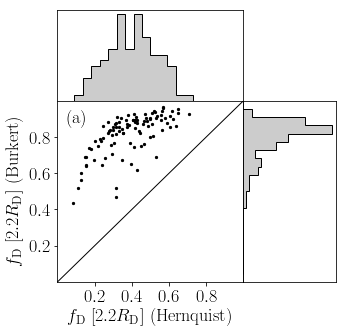

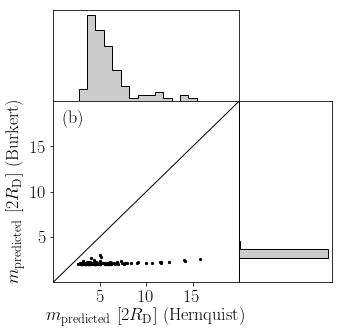

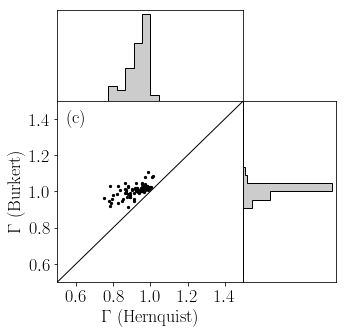

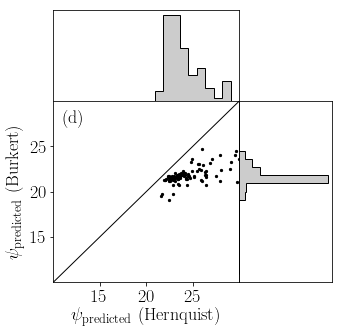

In [21]:
x = halo_data['disc_frac_2.2_hernquist'][unbarred_sample]
y = halo_data['disc_frac_2.2_burkert'][unbarred_sample]
bins = np.linspace(0,1,21)
xlabel = '$f_\mathrm{D}$ [$2.2R_\mathrm{D}$] (Hernquist)'
ylabel = '$f_\mathrm{D}$ [$2.2R_\mathrm{D}$] (Burkert)'

fig, axarr = xy_plotter(x,y,bins,False,xlabel,ylabel,'a')
axarr[2].set_xticks([0.2,0.4,0.6,0.8])
fig.savefig('figures/fd_vs_fd.pdf')

##################################################

x = halo_data['m_hernquist_2R_d'][unbarred_sample]
y = halo_data['m_burkert_2R_d'][unbarred_sample]
bins = np.linspace(0,20,21)
xlabel = '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$] (Hernquist)'
ylabel = '$m_\mathrm{predicted}$ [$2R_\mathrm{D}$] (Burkert)'

fig, axarr = xy_plotter(x,y,bins,False,xlabel,ylabel,'b')
_ = axarr[2].set_xticks([5,10,15])
fig.savefig('figures/mp_vs_mp.pdf')

###################################################

x = halo_data['Gamma_hernquist'][unbarred_sample]
y = halo_data['Gamma_burkert'][unbarred_sample]
bins = np.linspace(0.5,1.5,21)
xlabel = '$\Gamma$ (Hernquist)'
ylabel = '$\Gamma$ (Burkert)'

fig, axarr = xy_plotter(x,y,bins,False,xlabel,ylabel,'c')
axarr[2].set_xticks([0.6,0.8,1.0,1.2,1.4])
fig.savefig('figures/Gamma_vs_Gamma.pdf')

###################################################

x = halo_data['psi_hernquist'][unbarred_sample]
y = halo_data['psi_burkert'][unbarred_sample]
bins = np.linspace(10,30,21)
xlabel = '$\psi_\mathrm{predicted}$ (Hernquist)'
ylabel = '$\psi_\mathrm{predicted}$ (Burkert)'

fig, axarr = xy_plotter(x,y,bins,False,xlabel,ylabel,'d')
_ = axarr[2].set_xticks([15,20,25])
#fig.savefig('figures/psip_vs_psip.pdf')

#### Check vs. observables

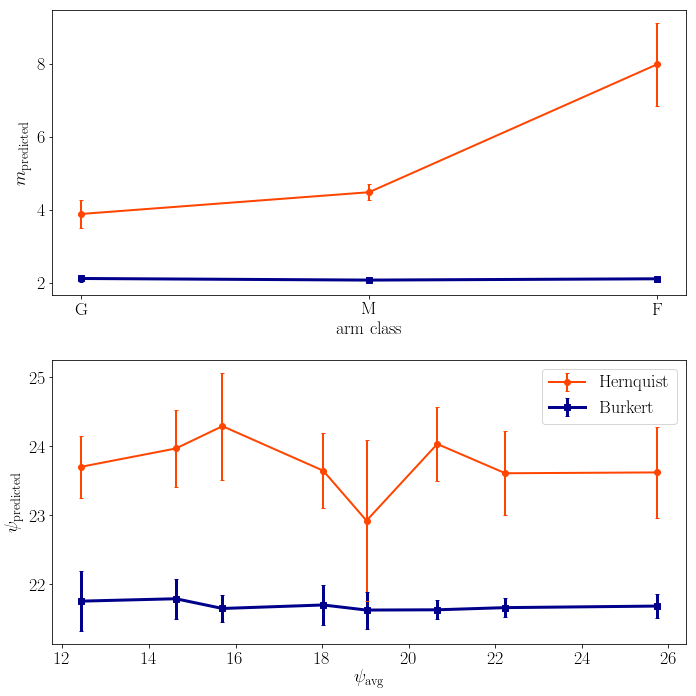

In [58]:
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,1,figsize=(10,10))

AC_number = np.zeros(len(morph_data))
AC_number[morph_data['AC'] == b'G'] = 1
AC_number[morph_data['AC'] == b'M'] = 2
AC_number[morph_data['AC'] == b'F'] = 3

########################################

ax = axarr[0]

x = AC_number[unbarred_sample]
y0 = halo_data['m_hernquist_2R_d'][unbarred_sample]
y1 = halo_data['m_burkert_2R_d'][unbarred_sample]

xy_hernquist = x_vs_y(x,y0).discrete_vs_continuous_binned_median()
xy_burkert = x_vs_y(x,y1).discrete_vs_continuous_binned_median()

xy_hernquist.error_plot(ax,style='errorbar',
        lw=2,color='orangered',capsize=2,marker='o',label='Hernquist')
xy_burkert.error_plot(ax,style='errorbar',
        lw=3,color='darkblue',capsize=2,marker='s',label='Burkert')

_ = ax.set_xticks([1,2,3])
_ = ax.set_xticklabels(['G','M','F'])
_ = ax.set_xlabel('arm class')
_ = ax.set_ylabel('$m_\mathrm{predicted}$')

########################################
ax = axarr[1]

x = psi_data['P_abs'][psi_unbarred]
y0 = halo_data['psi_hernquist'][psi_unbarred]
y1 = halo_data['psi_burkert'][psi_unbarred]

xy_hernquist = x_vs_y(x,y0).continuous_vs_continuous_binned_median(
    equal_N=True,bins=8)
xy_burkert = x_vs_y(x,y1).continuous_vs_continuous_binned_median(
    equal_N=True,bins=8)

xy_hernquist.error_plot(ax,style='errorbar',
            lw=2,color='orangered',capsize=2,marker='o',label='Hernquist')
xy_burkert.error_plot(ax,style='errorbar',
            lw=3,color='darkblue',capsize=2,marker='s',label='Burkert')

_ = ax.set_xlabel('$\psi_\mathrm{avg}$')
_ = ax.set_ylabel('$\psi_\mathrm{predicted}$')
_ = ax.legend()

fig.tight_layout()